In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [68]:
Base_dir= r"D:\yupp"
data = pd.read_csv(r"D:\yupp\captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [17]:
# load vgg
model = VGG16()

# cut layer
model = Model(
    inputs = model.input,
    outputs = model.layers[-2].output
)

# show
print(model.summary())


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
features={}
directory=os.path.join(Base_dir,'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path=directory +'/'+ img_name
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [67]:
with open(os.path.join(Base_dir,'captions.txt'),'r') as File:
    next(File)
    captions_file=File.read()

mapping = {}
for line in tqdm(captions_file.split('\n')):
    tokens = line.split(',')
    #Skips lines with fewer than 2 characters (likely blank lines)
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [21]:
def preprocessing(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

preprocessing(mapping)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\autad\AppData\Local\Temp\ipykernel_21440\2601420514.py:6: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [22]:
all_captions = [caption for key in mapping for caption in mapping[key]]


In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Initialize the Keras utility for word-level text tokenization
tokenizer = Tokenizer()

# Build the vocabulary: index words based on frequency across all captions
tokenizer.fit_on_texts(all_captions)

# Determine the total vocabulary size (add 1 for the reserved padding/OOD index)
vocab_size = len(tokenizer.word_index) + 1

# Find the maximum length of any caption sequence in the dataset
# This value will be used later for sequence padding/truncation
max_length = max(len(caption.split()) for caption in all_captions)

# Retrieve the unique identifiers (keys) for all available images
image_ids = list(mapping.keys())

train, test = train_test_split(image_ids, 
                               test_size=0.1, 
                               random_state=42)

In [65]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [] , [] ,[]
    n = 0
    
    # Loop indefinitely for Keras training
    while True:
        for key in data_keys:
            captions = mapping[key]
            
            # Create training sequences (input/output pairs)
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    # Prepare and pad the data
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            n += 1
            
            # Check if the batch is full
            if n == batch_size:
                # Yield the complete batch
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                
                X1.clear()
                X2.clear()
                y.clear()
                n = 0

In [26]:
# image feature layers
#4096 is the output of second last layer of the vgg16
inputs1=Input(shape=(4096,),name="image")
a=Dropout(0.3)(inputs1)
X=Dense(256,activation='relu')(a)

# sequence feature layers
inputs2=Input(shape=(max_length,),name="text")
c=Embedding(vocab_size,256)(inputs2)
d=Dropout(0.3)(c)
Y=LSTM(256)(d)



decoder1=add([X , Y])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)             │ (None, 35)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ image (InputLayer)            │ (None, 4096)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 35, 256)           │       2,172,160 │ text[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 4096)              │               0 │ image[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 35, 256)           │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │       1,048,832 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 256)               │         525,312 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dense[0][0], lstm[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │          65,792 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 8485)              │       2,180,645 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 5,992,741 (22.86 MB)

 Trainable params: 5,992,741 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:


epochs=12
batch_size=32
steps=len(train)//batch_size

for i in range(epochs):
    generator=data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator, epochs=1,steps_per_epoch=steps,verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - loss: 5.0763
227/227 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - loss: 3.8717
227/227 ━━━━━━━━━━━━━━━━━━━━ 601s 3s/step - loss: 3.4573
227/227 ━━━━━━━━━━━━━━━━━━━━ 608s 3s/step - loss: 3.1899
227/227 ━━━━━━━━━━━━━━━━━━━━ 637s 3s/step - loss: 3.0009
227/227 ━━━━━━━━━━━━━━━━━━━━ 659s 3s/step - loss: 2.8686
227/227 ━━━━━━━━━━━━━━━━━━━━ 679s 3s/step - loss: 2.7630
227/227 ━━━━━━━━━━━━━━━━━━━━ 677s 3s/step - loss: 2.6695
227/227 ━━━━━━━━━━━━━━━━━━━━ 730s 3s/step - loss: 2.5942
227/227 ━━━━━━━━━━━━━━━━━━━━ 805s 4s/step - loss: 2.5236
227/227 ━━━━━━━━━━━━━━━━━━━━ 782s 3s/step - loss: 2.4641
227/227 ━━━━━━━━━━━━━━━━━━━━ 4193s 19s/step - loss: 2.4138


In [28]:
def convert_to_word(number, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == number:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = convert_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text


startseq brown dog running through field endseq


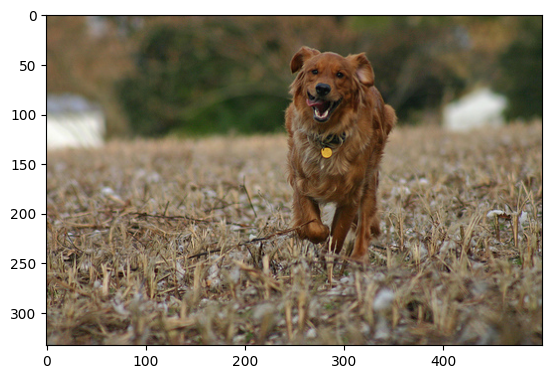

In [70]:
def generate_caption(image_name):
    base_filename = os.path.basename(image_name) 
    # Extract the image ID 
    image_id = base_filename.split('.')[0]
    img_path = image_name
    image = Image.open(img_path)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)
generate_caption(r"D:\yupp\Images\69189650_6687da7280.jpg")


In [38]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = [] , []

for key in tqdm(test):

    captions = mapping[key] 
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

    # calcuate BLEU score
#Unigram
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#Bigram
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.546586
BLEU-2: 0.325619


In [39]:

model.save('FinalPromodel.keras')



In [40]:
pickle.dump(tokenizer , open('tokenizer.pkl','wb'))

startseq hiker is standing on top of mountain overlooking the mountains endseq


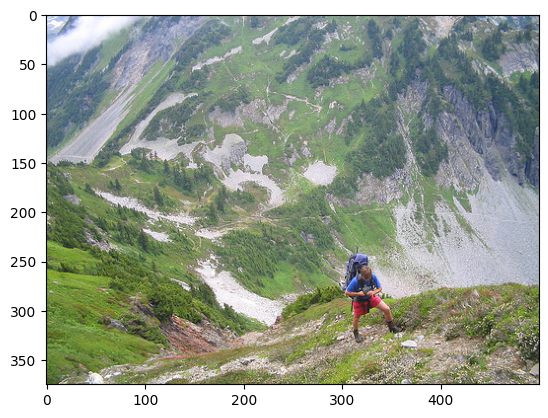

In [56]:
from PIL import Image
import matplotlib.pyplot as plt
import os # Make sure you have this import!

#sample test output

def generate_caption(image_name):
    base_filename = os.path.basename(image_name) 
    # Extract the image ID 
    image_id = base_filename.split('.')[0]
    img_path = image_name
    image = Image.open(img_path)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)

# Example call using the full path
generate_caption(r"D:\yupp\Images\58363928_6f7074608c.jpg")

In [75]:
!pip install gradio Pillow --quiet

import gradio as gr
from PIL import Image
import numpy as np
import os
import tensorflow as tf
import pickle
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Flatten
from tensorflow.keras.models import Model # Necessary for defining the feature extractor

max_length = 35 
VGG_model = None
caption_model = None
tokenizer = None
feature_extractor_model = None

try:
    MODEL_WEIGHTS_PATH = r"C:\Users\autad\image_caption\Promodel.keras"
    TOKENIZER_PATH = r"C:\Users\autad\image_caption\tokenizer.pkl"    

    VGG_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = VGG_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='relu')(x) 
    
    feature_extractor_model = Model(inputs=VGG_base.input, outputs=x)
    caption_model = tf.keras.models.load_model(MODEL_WEIGHTS_PATH)

    with open(TOKENIZER_PATH, 'rb') as f:
        tokenizer = pickle.load(f)
        
    print("Model assets loaded/initialized successfully.")

except Exception as e:
    print(f"ERROR: Failed to load model assets. Check file paths. Error: {e}")

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image_feature, tokenizer, max_length):
    in_text = 'startseq'
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)[0]
        yhat = model.predict([image_feature, np.array([sequence])], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        
        if word is None:
            break
       
        in_text += ' ' + word
        
        if word == 'endseq':
            break
            
    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()
    return final_caption

def generate_caption(image_input):
    if image_input is None:
        return "Please upload an image to generate a caption."

    if feature_extractor_model is None or caption_model is None or tokenizer is None:
        return "Model assets failed to load. Check console for file path errors."

    try:
        TARGET_SIZE = (224, 224)
        
        # 1. Image Preprocessing
        img = image_input.resize(TARGET_SIZE)
        img_array = np.array(img, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Use VGG's specific preprocessing
        img_array = preprocess_input(img_array)
        
        # 2. Feature Extraction (Encoder) using the fixed extractor model
        # This now correctly outputs the (1, 4096) feature vector.
        image_feature = feature_extractor_model.predict(img_array, verbose=0)
        
        # 3. Caption Generation (Decoder)
        final_caption = predict_caption(caption_model, image_feature, tokenizer, max_length) 
        
        return final_caption
        
    except Exception as e:
        return f"An error occurred during caption generation: {str(e)}"

image_input = gr.Image(
    type="pil", 
    label="Upload Image", 
    height=400, 
    sources=["upload"] 
)

caption_output = gr.Textbox(
    label="Generated Caption", 
    lines=3, 
    placeholder="Your generated caption will appear here once the model runs...",
    show_copy_button=True
)

interface = gr.Interface(
    fn=generate_caption,
    inputs=image_input,
    outputs=caption_output,
    title="Image Caption Generator (Gradio)",
    description="Upload an image and the trained deep learning model will generate a descriptive caption in real-time.",
    theme=gr.themes.Soft(), 
    allow_flagging='never'
)

interface.launch(
    share=False, 
    inbrowser=False, 
    max_threads=10 
)

C:\Users\autad\AppData\Roaming\Python\Python313\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\autad\AppData\Roaming\Python\Python313\site-packages\gradio\interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Model assets loaded/initialized successfully.
* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.
